In [22]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [5]:
df = pd.read_csv("/workspaces/StellarDatasetML/data/stellar_eda.csv")

In [6]:
# recode response variable to 0/1/2
#df = df.replace({"class": {"STAR": 0, "GALAXY": 1, "QSO": 2}})

# Trial 2

In [7]:
target = df['class'].copy()
data = df.drop(columns=['class']).copy()

In [8]:
target.value_counts()

GALAXY    47556
STAR      17274
QSO       15169
Name: class, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

fitting a knn model

In [10]:
def accuracy(y_test, y_preds):
    """Calculates inference accuracy of the model.
    
    Args-
        y_test- Original target labels of the test set
        y_preds- Predicted target lables
    Returns-
        acc
    """
    total_correct = 0
    for i in range(len(y_test)):
        if int(y_test[i]) == int(y_preds[i]):
            total_correct += 1
    acc = total_correct/len(y_test)
    return acc

In [11]:
# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

# create KNN model object
knn = KNeighborsClassifier(n_neighbors=5)

# define loss function
loss = 'accuracy'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(knn, X_train_std, y_train, cv=kfold, scoring=loss)


np.round(results, 3)

array([0.904, 0.903, 0.903, 0.903, 0.905])

## Tuning

In [12]:
# create KNN model object
knn = KNeighborsClassifier()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(1, 20, 5)}



In [13]:
# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_std, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

0.9003553490107535

In [14]:
# Best model's k value
optimal_k = results.best_estimator_.get_params().get('n_neighbors')
optimal_k

1

In [19]:
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best_fit = knn_best.fit(X_train_std, y_train)

predictions = knn_best_fit.predict(X_train_std)
cm = confusion_matrix(y_train, predictions)
cm

array([[33206,     0,     0],
       [    0, 10711,     0],
       [    0,     0, 12082]])

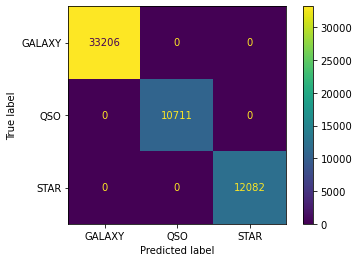

In [20]:
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=knn_best_fit.classes_
  )
  
disp.plot()

In [23]:
r = permutation_importance(
  knn_best_fit, 
  X_train_std, 
  y_train,
  n_repeats=30,
  random_state=0
  )

In [ ]:
vip = pd.DataFrame({'feature': X_train.columns.values,
                    'importance': r.importances_mean})

In [21]:

                    
(ggplot(vip, aes('importance', 'reorder(feature, importance)'))
  + geom_point()
  + labs(y=None))

KeyboardInterrupt: 

In [ ]:
pd_results = partial_dependence(
  knn_best_fit, X_train_std, features=1, kind='average',
  percentiles=(0, 1)) 
  
  
pd_output = pd.DataFrame({'glucose': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('glucose', 'yhat'))
  + geom_line())